# Description
Compares self-normalizing MLPs with regular MLPs.
Compares the performance of a simple MLP using two
different activation functions: RELU and SELU
on the Reuters newswire topic classification task.
### Reference
- Klambauer, G., Unterthiner, T., Mayr, A., & Hochreiter, S. (2017).
  Self-Normalizing Neural Networks. arXiv preprint arXiv:1706.02515.
  https://arxiv.org/abs/1706.02515

In [1]:
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.datasets import reuters
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.layers.noise import AlphaDropout
from keras.preprocessing.text import Tokenizer

Using TensorFlow backend.


Loading data...
2113536/2110848 [==============================] - 28s 13us/step
8982 train sequences
2246 test sequences
46 classes
Vectorizing sequence data...
x_train shape: (8982, 1000)
x_test shape: (2246, 1000)
Convert class vector to binary class matrix (for use with categorical_crossentropy)
y_train shape: (8982, 46)
y_test shape: (2246, 46)

Building network 1...
Train on 8083 samples, validate on 899 samples
Epoch 1/10
8083/8083 [==============================] - 4s 443us/step - loss: 3.3697 - acc: 0.3296 - val_loss: 2.9014 - val_acc: 0.3315
Epoch 2/10
8083/8083 [==============================] - 2s 269us/step - loss: 2.7354 - acc: 0.3494 - val_loss: 2.5973 - val_acc: 0.3315
Epoch 3/10
8083/8083 [==============================] - 2s 272us/step - loss: 2.5458 - acc: 0.3437 - val_loss: 2.4770 - val_acc: 0.3315
Epoch 4/10
8083/8083 [==============================] - 2s 304us/step - loss: 2.4298 - acc: 0.3467 - val_loss: 2.3200 - val_acc: 0.3315
Epoch 5/10
8083/8083 [============

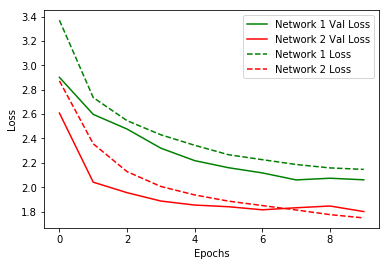

In [2]:
max_words = 1000
batch_size = 16
epochs = 10
plot = True


def create_network(n_dense=6,
                   dense_units=16,
                   activation='selu',
                   dropout=AlphaDropout,
                   dropout_rate=0.1,
                   kernel_initializer='lecun_normal',
                   optimizer='adam',
                   num_classes=1,
                   max_words=max_words):
    """Generic function to create a fully-connected neural network.
    # Arguments
        n_dense: int > 0. Number of dense layers.
        dense_units: int > 0. Number of dense units per layer.
        dropout: keras.layers.Layer. A dropout layer to apply.
        dropout_rate: 0 <= float <= 1. The rate of dropout.
        kernel_initializer: str. The initializer for the weights.
        optimizer: str/keras.optimizers.Optimizer. The optimizer to use.
        num_classes: int > 0. The number of classes to predict.
        max_words: int > 0. The maximum number of words per data point.
    # Returns
        A Keras model instance (compiled).
    """
    model = Sequential()
    model.add(Dense(dense_units, input_shape=(max_words,),
                    kernel_initializer=kernel_initializer))
    model.add(Activation(activation))
    model.add(dropout(dropout_rate))

    for i in range(n_dense - 1):
        model.add(Dense(dense_units, kernel_initializer=kernel_initializer))
        model.add(Activation(activation))
        model.add(dropout(dropout_rate))

    model.add(Dense(num_classes))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])
    return model


network1 = {
    'n_dense': 6,
    'dense_units': 16,
    'activation': 'relu',
    'dropout': Dropout,
    'dropout_rate': 0.5,
    'kernel_initializer': 'glorot_uniform',
    'optimizer': 'sgd'
}

network2 = {
    'n_dense': 6,
    'dense_units': 16,
    'activation': 'selu',
    'dropout': AlphaDropout,
    'dropout_rate': 0.1,
    'kernel_initializer': 'lecun_normal',
    'optimizer': 'sgd'
}

print('Loading data...')
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=max_words,
                                                         test_split=0.2)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

num_classes = np.max(y_train) + 1
print(num_classes, 'classes')

print('Vectorizing sequence data...')
tokenizer = Tokenizer(num_words=max_words)
x_train = tokenizer.sequences_to_matrix(x_train, mode='binary')
x_test = tokenizer.sequences_to_matrix(x_test, mode='binary')
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

print('Convert class vector to binary class matrix '
      '(for use with categorical_crossentropy)')
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

print('\nBuilding network 1...')

model1 = create_network(num_classes=num_classes, **network1)
history_model1 = model1.fit(x_train,
                            y_train,
                            batch_size=batch_size,
                            epochs=epochs,
                            verbose=1,
                            validation_split=0.1)

score_model1 = model1.evaluate(x_test,
                               y_test,
                               batch_size=batch_size,
                               verbose=1)


print('\nBuilding network 2...')
model2 = create_network(num_classes=num_classes, **network2)

history_model2 = model2.fit(x_train,
                            y_train,
                            batch_size=batch_size,
                            epochs=epochs,
                            verbose=1,
                            validation_split=0.1)

score_model2 = model2.evaluate(x_test,
                               y_test,
                               batch_size=batch_size,
                               verbose=1)

print('\nNetwork 1 results')
print('Hyperparameters:', network1)
print('Test score:', score_model1[0])
print('Test accuracy:', score_model1[1])
print('Network 2 results')
print('Hyperparameters:', network2)
print('Test score:', score_model2[0])
print('Test accuracy:', score_model2[1])

plt.plot(range(epochs),
         history_model1.history['val_loss'],
         'g-',
         label='Network 1 Val Loss')
plt.plot(range(epochs),
         history_model2.history['val_loss'],
         'r-',
         label='Network 2 Val Loss')
plt.plot(range(epochs),
         history_model1.history['loss'],
         'g--',
         label='Network 1 Loss')
plt.plot(range(epochs),
         history_model2.history['loss'],
         'r--',
         label='Network 2 Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('comparison_of_networks.png')